<a href="https://colab.research.google.com/github/talhaanwarch/Plant-Leaf-Disease-Classification/blob/master/transfer_learning_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### download data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!wget https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip

--2020-03-31 01:35:05--  https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86, 2606:4700:7::a29f:8556, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb [following]
--2020-03-31 01:35:06--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.106.160
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.106.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66977095 (64

### install efficinetnet model

In [3]:
!pip install efficientnet

### unzip donwloaded dataset

In [4]:
!unzip /content/Citrus.zip

Archive:  /content/Citrus.zip
   creating: Citrus/
   creating: Citrus/Fruits/
   creating: Citrus/Fruits/Black spot/
  inflating: Citrus/Fruits/Black spot/Black spot (1).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (10).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (11).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (12).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (13).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (14).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (15).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (16).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (17).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (18).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (19).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (2).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (3).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (4).jpg  
  inflating: Citrus/Fruits/Black spot/Black sp

## import libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


## data augmentation 

In [0]:
from keras_preprocessing.image import ImageDataGenerator

data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.3)

## load data 
load data from directory in generator structure, infact data is loaded while training

In [0]:
img_shape=300
batch_size=16

In [8]:
#load the training data
train_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)


Found 429 images belonging to 5 classes.


In [9]:
#load the training data
val_suffle=False
val_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=16,
    class_mode='categorical',
    subset='validation',shuffle=val_suffle)#shuffle should be False in validation
    #https://stackoverflow.com/a/47439789/11170350


Found 180 images belonging to 5 classes.


In [10]:
train_generator.next()[0].shape,train_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

In [11]:
val_generator.next()[0].shape,val_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

## create efficent net architecture

In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

### Base model

In [13]:
import efficientnet.tfkeras as efn
model =efn.EfficientNetB4(weights ='noisy-student', include_top=False, input_shape = (img_shape,img_shape,3))


71680000/71678424 [==============================] - 2s 0us/step


In [0]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [18]:

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 17,911,901
Trainable params: 17,786,701
Non-trainable params: 125,200


In [19]:
results = model.fit(train_generator,epochs=15,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

Epoch 1/15
27/26 [==============================] - 23s 866ms/step - loss: 1.1469 - accuracy: 0.6200 - val_loss: 1.3838 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 2/15
27/26 [==============================] - 20s 756ms/step - loss: 0.7610 - accuracy: 0.8578 - val_loss: 1.2587 - val_accuracy: 0.5889 - lr: 0.0010
Epoch 3/15
27/26 [==============================] - 20s 758ms/step - loss: 0.7711 - accuracy: 0.8392 - val_loss: 0.9581 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 4/15
27/26 [==============================] - 21s 763ms/step - loss: 0.6582 - accuracy: 0.8951 - val_loss: 0.9166 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 5/15
27/26 [==============================] - 20s 754ms/step - loss: 0.6986 - accuracy: 0.8834 - val_loss: 0.9988 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 6/15
27/26 [==============================] - 21s 761ms/step - loss: 0.6257 - accuracy: 0.8974 - val_loss: 1.3170 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 7/15
27/26 [==============================] - 20s 757ms/st

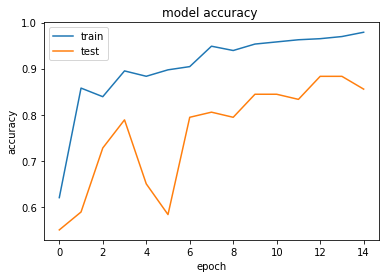

In [20]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

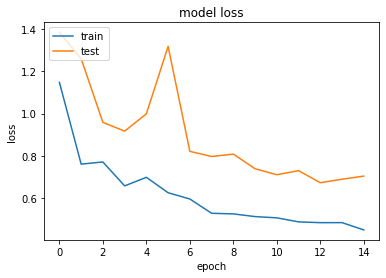

In [21]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 363ms/step - loss: 0.7226 - accuracy: 0.8476


[0.7225928902626038, 0.8475610017776489]

In [23]:
val_generator.reset()
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 387ms/step - loss: 0.7178 - accuracy: 0.8750


[0.7178135514259338, 0.875]

In [24]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

12/11 [================================] - 4s 365ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [27]:
y_pred.shape,y_true.shape

((180,), (180,))

In [28]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.8833333333333333
0.921791728797567


In [29]:
class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.79      0.90      0.84        51
    Melanose       1.00      1.00      1.00         3
      canker       0.95      0.83      0.89        48
    greening       0.88      0.87      0.88        61
     healthy       1.00      1.00      1.00        17

    accuracy                           0.88       180
   macro avg       0.93      0.92      0.92       180
weighted avg       0.89      0.88      0.88       180



### Imagenet weights

In [30]:
import efficientnet.tfkeras as efn
model =efn.EfficientNetB4(weights = 'imagenet', include_top=False, input_shape = (img_shape,img_shape,3))


71892992/71892840 [==============================] - 2s 0us/step


In [0]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [35]:

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 17,911,901
Trainable params: 17,786,701
Non-trainable params: 125,200


In [36]:
results = model.fit(train_generator,epochs=15,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

Epoch 1/15
27/26 [==============================] - 22s 831ms/step - loss: 1.0565 - accuracy: 0.6760 - val_loss: 1.4200 - val_accuracy: 0.4778 - lr: 0.0010
Epoch 2/15
27/26 [==============================] - 20s 754ms/step - loss: 0.8919 - accuracy: 0.7809 - val_loss: 1.4557 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 3/15
27/26 [==============================] - 20s 755ms/step - loss: 0.6588 - accuracy: 0.8951 - val_loss: 1.3160 - val_accuracy: 0.5722 - lr: 0.0010
Epoch 4/15
27/26 [==============================] - 20s 758ms/step - loss: 0.6252 - accuracy: 0.9114 - val_loss: 1.1568 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 5/15
27/26 [==============================] - 20s 751ms/step - loss: 0.6145 - accuracy: 0.9207 - val_loss: 1.0650 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/15
27/26 [==============================] - 20s 756ms/step - loss: 0.6222 - accuracy: 0.9114 - val_loss: 0.9085 - val_accuracy: 0.7944 - lr: 0.0010
Epoch 7/15
27/26 [==============================] - 20s 754ms/st

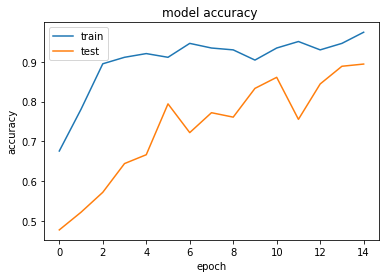

In [37]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 59


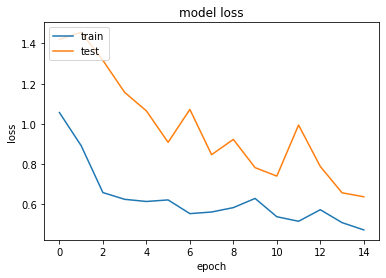

In [38]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 357ms/step - loss: 0.6444 - accuracy: 0.8780


[0.6443590521812439, 0.8780487775802612]

In [40]:
val_generator.reset()
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 389ms/step - loss: 0.6824 - accuracy: 0.8750


[0.6823627948760986, 0.875]

In [41]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

12/11 [================================] - 4s 370ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [44]:
y_pred.shape,y_true.shape

((180,), (180,))

In [45]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.8722222222222222
0.914936247723133


In [46]:
class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.79      0.88      0.83        51
    Melanose       1.00      1.00      1.00         3
      canker       0.95      0.83      0.89        48
    greening       0.85      0.85      0.85        61
     healthy       1.00      1.00      1.00        17

    accuracy                           0.87       180
   macro avg       0.92      0.91      0.91       180
weighted avg       0.88      0.87      0.87       180



# Similar task transfer learning

##download pretrained model
We trained this model on kaggle 
https://www.kaggle.com/chtalhaanwar/keras-efficientnet?scriptVersionId=30290935
For each either download the model directly from kaggle given link below, if it does not work, you need to download it manually and upload it in google drive or here directly

In [0]:
#!wget https://www.kaggleusercontent.com/kf/31126480/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..tHB2-QNYsfqKBXukuQX30A.RmXgMxIt2sYEoJiyZg6ry9MrtxHLkDLoaojnvhIRtN5Pm-I3r2dlwxwYF0S8D1hs876KSQHU3Ju2QqrJiE1Ey_x8gFUTXq_d7QjO2TyQ9InbWfusw_nLbytbhs-ZGSG2zeaktKstevFa5T-u0O0VjuU1kayaHFXgZt-kLPaLoSHHbcpZCWXzw79MHIxWMdd2ZbkoJRmfMvXxElgbQ27ylbdAOc2yDJdcWXVzKF_aCkFH4k7CLQlYnh_nzPPbp0_bu6I7ZbNARD_g9jc3RQB0tg-Asz2AHF5aVGF7B3y-jWRSX3XG642lO3MNBMzm-X6UGlJoehtieQPHJj5Ky36Ir8hCM-jXyXgoJlTdOiZC61jpn_Kt7nzqHvHBPk_GFBC14wkdZmF3njakznhuSacZbkChJx9g-QGVRZWzGmRlkbDb23MsxFxQ3qpf8M4tV7vsQW0EhsRDI3QMDVKRZdmLJqgRlr5v3WHfPlJH9Dtcm0kK1r5tPzXPdciMhan3w2mf1pZmmCorHhwA7uvbd80iRLgY81g1irGEei3bGltjYSuI2JwaoTu3E5UP8vywT_wTSzwpFrY-38ENlqvqefbtYRQffLQjtPSZVYcvY7rKzviZakJrc0knW08QpZiNgPVmj0uLTCammTlwteSp3dbppK35NcgQgMzEJl-49-MP0wQ.tWGgsGxGaJxEmba-Q8zUVA/model_weights.h5

In [0]:
#cp /content/model_weights.h5 /content/drive/My\ Drive/data/

In [0]:
cp /content/drive/My\ Drive/data/model_weights.h5 /content

In [50]:
transfer_model =efn.EfficientNetB4(weights = None, include_top=False, input_shape = (img_shape,img_shape,3))
x = transfer_model.output
print(x.shape)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
transfer_predictions = Dense(4, activation="softmax")(x)
transfer_model = Model(inputs=transfer_model.input, outputs=transfer_predictions)
transfer_model.load_weights('model_weights.h5')

(None, 10, 10, 1792)


In [0]:
for layer in transfer_model.layers[:-4]:
    layer.trainable = False

In [0]:
# for i in transfer_model.layers:
#   print(i,i.trainable)

In [53]:
trainable_count = np.sum([K.count_params(w) for w in transfer_model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in transfer_model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 17,911,836
Trainable params: 238,020
Non-trainable params: 17,673,816


In [0]:
transfer_model2 = Model(transfer_model.input, transfer_model.layers[-7].output)

In [55]:
x = transfer_model2.output
print(x.shape)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)

transfer_predictions = Dense(5, activation="softmax")(x)
transfer_model2 = Model(inputs=transfer_model2.input, outputs=transfer_predictions)

(None, 10, 10, 1792)


In [56]:
trainable_count = np.sum([K.count_params(w) for w in transfer_model2.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in transfer_model2.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 17,911,901
Trainable params: 238,085
Non-trainable params: 17,673,816


In [0]:
transfer_model2.compile(optimizer=Adam(0.0001), loss=custom_loss, metrics=['accuracy'])

In [58]:
results = transfer_model2.fit(train_generator,epochs=15,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.0000001)])

Epoch 1/15
27/26 [==============================] - 18s 680ms/step - loss: 1.5340 - accuracy: 0.3054 - val_loss: 1.4393 - val_accuracy: 0.5278 - lr: 1.0000e-04
Epoch 2/15
27/26 [==============================] - 16s 604ms/step - loss: 1.3992 - accuracy: 0.4149 - val_loss: 1.3802 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 3/15
27/26 [==============================] - 16s 610ms/step - loss: 1.3301 - accuracy: 0.4732 - val_loss: 1.2970 - val_accuracy: 0.5722 - lr: 1.0000e-04
Epoch 4/15
27/26 [==============================] - 16s 605ms/step - loss: 1.2391 - accuracy: 0.5291 - val_loss: 1.2365 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 5/15
27/26 [==============================] - 16s 607ms/step - loss: 1.2140 - accuracy: 0.5781 - val_loss: 1.1569 - val_accuracy: 0.7111 - lr: 1.0000e-04
Epoch 6/15
27/26 [==============================] - 16s 601ms/step - loss: 1.1398 - accuracy: 0.5711 - val_loss: 1.1179 - val_accuracy: 0.6722 - lr: 1.0000e-04
Epoch 7/15
27/26 [======================

In [0]:
# import gc
# del transfer_model2
# tf.keras.backend.clear_session()
# gc.collect()

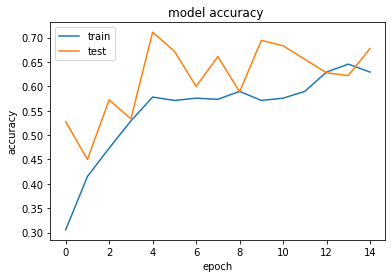

In [60]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

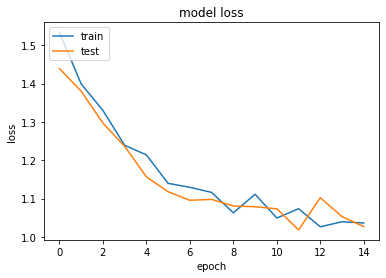

In [61]:
import matplotlib.pyplot as plt

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
transfer_model2.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 356ms/step - loss: 1.0704 - accuracy: 0.6463


[1.0704381465911865, 0.6463414430618286]

In [63]:
val_generator.reset()
transfer_model2.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 378ms/step - loss: 1.0027 - accuracy: 0.6705


[1.0027271509170532, 0.6704545617103577]

In [64]:
val_generator.reset()
y_pred=transfer_model2.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

12/11 [================================] - 4s 364ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [67]:
y_pred.shape,y_true.shape

((180,), (180,))

In [68]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.6777777777777778
0.6221886786075255


In [69]:
class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.77      0.47      0.59        51
    Melanose       1.00      0.67      0.80         3
      canker       0.89      0.83      0.86        48
    greening       0.56      0.89      0.68        61
     healthy       0.40      0.12      0.18        17

    accuracy                           0.68       180
   macro avg       0.72      0.59      0.62       180
weighted avg       0.70      0.68      0.66       180

